## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

zsh:1: command not found: wget
unzip:  cannot find or open ml-1m.zip, ml-1m.zip.zip or ml-1m.zip.ZIP.
cat: ml-1m/README: No such file or directory


In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
matrix_shape = (df_train['user_id'].nunique(), df_train['item_id'].nunique())

In [11]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = np.zeros((matrix_shape))
    result[df.user_id.values, df.item_id.values] = df.rating.values

    return result  #shape ~ [n_users, n_items]

In [12]:
interactions = df_to_matrix(df_train)

In [35]:
from scipy.sparse import coo_array, csr_matrix


def df_to_coo(df: pd.DataFrame) -> coo_array:
    result = coo_array(
        (df.rating.values.astype(float), (df.user_id.values, df.item_id.values)),
        shape=(matrix_shape)
    )

    return result  # coo_array

In [17]:
coo_interactions = df_to_coo(df_train)

In [18]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [ ]:
import scipy.sparse as scps

In [21]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    if isinstance(interactions, np.ndarray):
        U, S, V = np.linalg.svd(interactions)
        U = U[:, :min(U.shape[0], V.shape[1])]
        V = V[:min(U.shape[0], V.shape[1]), :]
        S = np.diag(S)

        if n_singular_values > 0:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values, :n_singular_values]
            V = V[:n_singular_values, :]

    elif isinstance(interactions, coo_array):
        if n_singular_values > 0:
            U, S, V = scps.linalg.svds(interactions, k=n_singular_values, random_state=42)
        else:
            U, S, V = scps.linalg.svds(interactions, k=min(interactions.shape) - 1, random_state=42)

        S = np.diag(S)

    else:
        raise ValueError(f"Unknown data type {type(interactions)}")

    return U, S, V

In [22]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [23]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [24]:
import gc

In [25]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1,
                             top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)
    matrix_pred = U @ S @ V

    if isinstance(interactions, coo_array):
        matrix_pred[scps.find(coo_interactions > 0)[:2]] = -np.inf
    elif isinstance(interactions, np.ndarray):
        matrix_pred[np.where(interactions > 0)] = -np.inf
    else:
        raise ValueError(f"Unknown data type {type(interactions)}")

    recommendations = np.argsort(-matrix_pred, axis=1)[:, :top_k]

    del matrix_pred; gc.collect()

    return recommendations #shape ~ [n_users, top_k]

In [26]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [27]:
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm

def ndcg(df_test, recs, verbose=False):
    y_true = np.empty(recs.shape)
    y_pred = np.vstack([-1 * np.arange(recs.shape[1]) for _ in range(recs.shape[0])])

    for user_id in tqdm(range(recs.shape[0]), disable= not verbose):
        relevance_true = np.isin(
            recs[user_id],
            df_test.loc[df_test.user_id == user_id]["item_id"].values
        ).astype(int)
        y_true[user_id] = relevance_true

    score = ndcg_score(y_true, y_pred)
    del y_true, y_pred

    return score

In [28]:
import matplotlib.pyplot as plt
import time

In [31]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    #your code here
    scores = []
    times = []
    n_singular_values = [1, 5, 10, 20, 50, 60, 100, 200, 500, 700, 1000]
    for singular_value in tqdm(n_singular_values):
        start = time.time()
        recs = make_svd_recommendations(interactions, singular_value, top_k)
        end = time.time()

        times.append(end - start)
        scores.append(ndcg(df_test, recs))

    fig, ax = plt.subplots(figsize=(10, 10), nrows=2)

    ax[0].plot(n_singular_values, scores)
    ax[0].set_xlabel("n_singular_values")
    ax[0].set_ylabel(f"nDCG @ {top_k}")


    ax[1].plot(n_singular_values, times)
    ax[1].set_xlabel("n_singular_values")
    ax[1].set_ylabel("Time")

    return fig, ax

#your code here


  0%|          | 0/11 [00:00<?, ?it/s]

(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: xlabel='n_singular_values', ylabel='nDCG @ 100'>,
        <Axes: xlabel='n_singular_values', ylabel='Time'>], dtype=object))

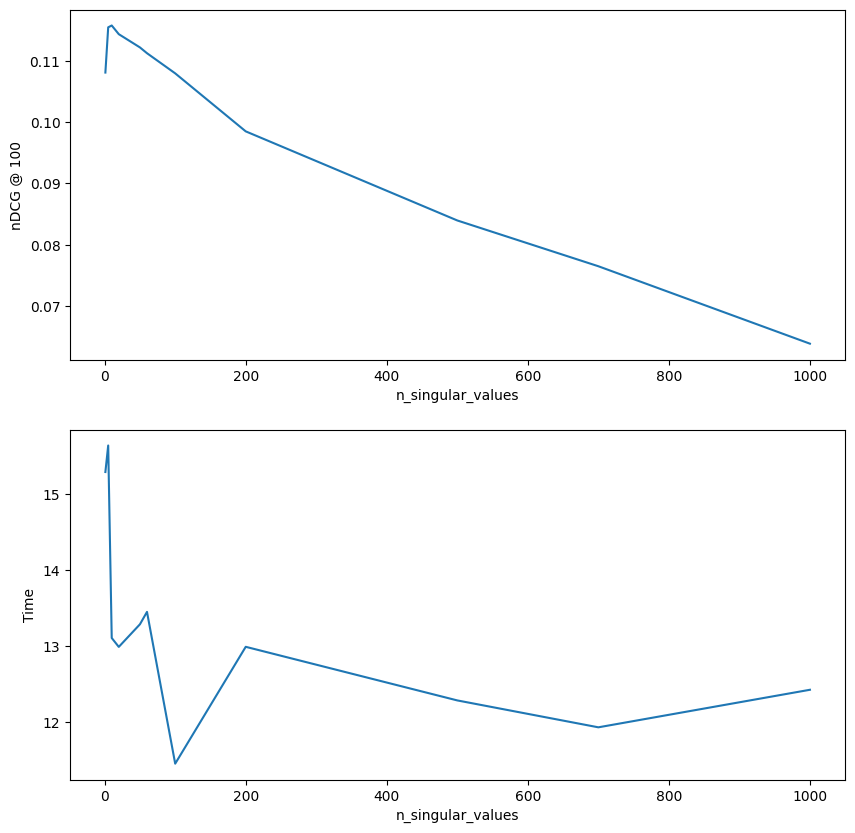

In [32]:
plot_graphs(coo_interactions)

Насчет времени и кол-вом сингулярных значений какой-то корреляции у меня нет._. (комп на M4 MAX). И насчет метрики качества, ее качество тоже не улучшается с увеличением кол-ва сингулярных значений. Возможно из-за того, что происходит переобучение._.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [36]:
from implicit.cpu.als import AlternatingLeastSquares
import scipy.sparse as scps
from copy import deepcopy

In [37]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
    verbose=True,
    return_model=False
):

    interactions = csr_matrix(deepcopy(interactions))
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        num_threads=6,
        random_state=42
    )

    model.fit(interactions, show_progress=verbose)

    recommendations = model.recommend(
        userid=np.arange(interactions.shape[0]),
        user_items=interactions,
        filter_already_liked_items=True, N=top_k
    )[0]

    del interactions

    if return_model:
        return recommendations, model
    return recommendations #shape ~ [n_users, top_k]


In [38]:
recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 14 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [40]:
print(f"ALS: {ndcg(df_test, recs):}")

svd_recs = make_svd_recommendations(coo_interactions, 15, 100)
print(f"SVD: {ndcg(df_test, svd_recs):.4f}")

ALS: 0.10687026869840936
SVD: 0.1147


In [44]:
# tuned als

alphas = [0, 0.5, 1, 2]
regularizations = [0.005, 0.01, 0.05, 0.1]
n_factors_ = [20, 50, 100, 150]

max_score = 0
best_combination = None

res = []

for alpha in tqdm(alphas):
    for regularization in regularizations:
        for n_factors in n_factors_:
            recs = make_als_recommendations(
                interactions,
                n_factors=n_factors,
                alpha=alpha,
                regularization=regularization,
                verbose=False
            )
            score = ndcg(df_test, recs)

            if score > max_score:
                print(f"New {score}")
                print(f"Parameters: {alpha}, {regularization}, {n_factors}")
                best_combination = (alpha, regularization, n_factors)
                max_score = score

            res.append((score, alpha, regularization, n_factors))

  0%|          | 0/4 [00:00<?, ?it/s]

New 0.06213329039676841
Parameters: 0, 0.005, 20
New 0.06686071167046065
Parameters: 0, 0.01, 100
New 0.07541060694217147
Parameters: 0, 0.05, 100
New 0.08044889619793838
Parameters: 0, 0.1, 150
New 0.11238423041059041
Parameters: 0.5, 0.005, 20


In [45]:
recs = make_als_recommendations(interactions, n_factors=20, alpha=0.5, regularization=0.05)
print(f"tuned als: {ndcg(df_test, recs):.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

tuned als: 0.1124


Обычный als справляется хуже всех, tuned als и svd примерно одинаково

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [46]:
import chardet
with open("ml-1m/movies.dat", mode="rb") as f:
    print(chardet.detect(f.read(9000)))

df_movies = pd.read_csv("ml-1m/movies.dat", sep=r'::', names=["item_id", "name", "genre"], engine="python", encoding="ISO-8859-1")

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [67]:
seed = 123
recs, model = make_als_recommendations(interactions, return_model=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [68]:
user = df_train.sample(random_state=seed)["user_id"].values[0]
user_recs = recs[user]

imp_movies = [i[0] for i in model.explain(user, csr_matrix(interactions), user_recs[0])[1]]


most_recom_id = item_le.inverse_transform(user_recs[[0]])[0]
imp_movies_ids = item_le.inverse_transform(imp_movies)

print(f"Recommendation for user {user}")

most_recom_movie = df_movies.loc[df_movies.item_id == most_recom_id].iloc[0]
print(f"Most recommended item: id={most_recom_movie.item_id}, name={most_recom_movie.name}, genre={most_recom_movie.genre}")

print("\nRecommendations are based on the user's views of the following movies:")
for movie_id in imp_movies_ids:
    movie = df_movies.loc[df_movies.item_id == movie_id].iloc[0]
    print(f"\t * id={movie.item_id}, name={movie.name}, genre={movie.genre}")


Recommendation for user 4948
Most recommended item: id=2716, name=2647, genre=Comedy|Horror

Recommendations are based on the user's views of the following movies:
	 * id=2987, name=2918, genre=Adventure|Animation|Film-Noir
	 * id=2918, name=2849, genre=Comedy
	 * id=2791, name=2722, genre=Comedy
	 * id=1079, name=1063, genre=Comedy
	 * id=2174, name=2105, genre=Comedy|Fantasy
	 * id=3361, name=3292, genre=Comedy
	 * id=3408, name=3339, genre=Drama
	 * id=1270, name=1250, genre=Comedy|Sci-Fi
	 * id=2763, name=2694, genre=Action|Thriller
	 * id=2797, name=2728, genre=Comedy|Fantasy


In [69]:
user = df_train.sample(random_state=seed + 1)["user_id"].values[0]
user_recs = recs[user]

imp_movies = [i[0] for i in model.explain(user, csr_matrix(interactions), user_recs[0])[1]]


most_recom_id = item_le.inverse_transform(user_recs[[0]])[0]
imp_movies_ids = item_le.inverse_transform(imp_movies)

print(f"Recommendation for user {user}")

most_recom_movie = df_movies.loc[df_movies.item_id == most_recom_id].iloc[0]
print(f"Most recommended item: id={most_recom_movie.item_id}, name={most_recom_movie.name}, genre={most_recom_movie.genre}")

print("\nRecommendations are based on the user's views of the following movies:")
for movie_id in imp_movies_ids:
    movie = df_movies.loc[df_movies.item_id == movie_id].iloc[0]
    print(f"\t * id={movie.item_id}, name={movie.name}, genre={movie.genre}")

Recommendation for user 4967
Most recommended item: id=2871, name=2802, genre=Adventure|Thriller

Recommendations are based on the user's views of the following movies:
	 * id=1204, name=1186, genre=Adventure|War
	 * id=3101, name=3032, genre=Thriller
	 * id=919, name=907, genre=Adventure|Children's|Drama|Musical
	 * id=1303, name=1283, genre=Adventure
	 * id=2819, name=2750, genre=Thriller
	 * id=590, name=586, genre=Adventure|Drama|Western
	 * id=1262, name=1242, genre=Adventure|War
	 * id=2987, name=2918, genre=Adventure|Animation|Film-Noir
	 * id=1294, name=1274, genre=Comedy|War
	 * id=111, name=109, genre=Drama|Thriller


##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [70]:
# 1

interactions_1 = deepcopy(interactions)
interactions_1[interactions_1 > 0] = 1

coo_interactions_1 = coo_array(interactions_1)

svd_recs = make_svd_recommendations(coo_interactions_1, 15, 100)
als_recs = make_als_recommendations(interactions_1, n_factors=20, alpha=0.5, regularization=0.05)
print(f"SVD: {ndcg(df_test, svd_recs): }")
print(f"ALS: {ndcg(df_test, als_recs): }")

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:  0.11472723604860942
ALS:  0.11151177025724732


SVD & ALS are quite similar

In [71]:
# 2

interactions_2 = deepcopy(interactions)
interactions_2[interactions_2 >= 4] = 1
interactions_2[interactions_2 <= 3] = 0

coo_interactions_2 = coo_array(interactions_2)

svd_recs = make_svd_recommendations(coo_interactions_2, 15, 100)
als_recs = make_als_recommendations(interactions_2, n_factors=20, alpha=0.5, regularization=0.05)
print(f"SVD: {ndcg(df_test, svd_recs): }")
print(f"ALS: {ndcg(df_test, als_recs): }")

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:  0.11472723604860942
ALS:  0.040235153638428084


SVD is better in this case

In [72]:
# 3

interactions_3 = deepcopy(interactions)
interactions_3[interactions_3 >= 4] = 1
interactions_3[interactions_3 <= 3] = -1

coo_interactions_3 = coo_array(interactions_3)

svd_recs = make_svd_recommendations(coo_interactions_3, 15, 100)
als_recs = make_als_recommendations(interactions_3, n_factors=20, alpha=0.5, regularization=0.05)
print(f"SVD: {ndcg(df_test, svd_recs): }")
print(f"ALS: {ndcg(df_test, als_recs): }")

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:  0.11472723604860942
ALS:  0.040235153638428084


SVD is better in this case

In [73]:
# 4

df_train["datetime"].min(), df_train["datetime"].min().month

(Timestamp('2000-04-25 23:05:32'), 4)

In [74]:
df_train["datetime"].max(), df_train["datetime"].max().month

(Timestamp('2000-11-30 23:59:47'), 11)

In [75]:
total_month = df_train["datetime"].max().month - df_train["datetime"].min().month # (n-4)/7

In [76]:
raitings = []
for i, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    if row["rating"] <= 3:
        raitings.append(-1)
        continue

    weight = (row["datetime"].month - 4) / 7
    raitings.append(row["rating"] * weight)


  0%|          | 0/787420 [00:00<?, ?it/s]

In [78]:
df_train_4 = deepcopy(df_train).assign(rating=raitings)
interactions_4 = df_to_matrix(df_train_4)
coo_interactions_4 = df_to_coo(df_train_4)


svd_recs = make_svd_recommendations(coo_interactions_4, 15, 100)
als_recs = make_als_recommendations(interactions_4, n_factors=20, alpha=0.5, regularization=0.05)
print(f"SVD: {ndcg(df_test, svd_recs): }")
print(f"ALS: {ndcg(df_test, als_recs): }")

  0%|          | 0/15 [00:00<?, ?it/s]

SVD:  0.11472723604860942
ALS:  0.11501249425212043


Хороший результат. Наравне с 1

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [83]:
import numpy as np

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10, verbose: bool = True):
        n_users, n_items = interactions.shape
        C = 1 + self.alpha * interactions
        I = np.eye(self.n_factors)

        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))

        for _ in tqdm(range(n_iterations), disable=not verbose):
            YTY = self.item_factors.T @ self.item_factors + self.reg_coef * I
            self.user_factors = np.linalg.solve(YTY, (C @ self.item_factors).T).T

            XTX = self.user_factors.T @ self.user_factors + self.reg_coef * I
            self.item_factors = np.linalg.solve(XTX, (C.T @ self.user_factors).T).T

    def predict(self, interactions: np.ndarray, top_k: int = 100) -> np.ndarray:
        scores = self.user_factors @ self.item_factors.T
        scores[interactions > 0] = -np.inf
        return np.argsort(-scores, axis=1)[:, :top_k]


In [86]:
model = iALS()
model.fit(interactions)
recs_manual = model.predict(interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

In [87]:
lib = make_als_recommendations(interactions)

  0%|          | 0/15 [00:00<?, ?it/s]

In [88]:
print(f"iALS: {ndcg(df_test, recs_manual): }")
print(f"lib: {ndcg(df_test, lib): }")

iALS:  0.10815880064195249
lib:  0.10687026869840936


наша модель получилась лучше